In [1]:
from memo import memo, domain
import jax.numpy as np
import jax
from enum import IntEnum
from matplotlib import pyplot as plt
from collections import defaultdict
import pandas as pd

In [109]:
class S(IntEnum):
    Coop = 0
    Defect = 1

class A(IntEnum):
    Coop = 0
    Defect   = 1

class O(IntEnum):
    Coop = 0
    Defect = 1

C = np.linspace(0, 1, 20) # Cooperation probability

# Volatility levels as indices
V = np.array([0, 1])

# Transition matrices Tr[v, s, s_]
# Low volatility: mostly stay
# High volatility: more switching
TR = np.array([
    [[0.95, 0.05],
     [0.05, 0.95]],

    [[0.5, 0.5],
     [0.5, 0.5]],
])

# Emission (Chris action) params:
# P(o=Coop | CoopMode) = p_hi,  P(o=Coop | DefMode) = p_lo
p_hi = 0.8
p_lo = 0.2

@jax.jit
def get_belief_prob(c, s):
    return np.array([c, 1-c])[s]

@jax.jit
def Tr(v, s, s_):
    return TR[v,s,s_]

@jax.jit
def obs(o, s):
    # P(o | s)
    p_coop = np.array([p_hi, p_lo])[s]  # s=0 -> p_hi, s=1 -> p_lo
    return np.array([p_coop, 1.0 - p_coop])[o]


# Human subjective utility parameters.
# If you set these all to 0, defection dominates and you will not get D->C switching.
k_mutual = 25.0   # bonus for mutual cooperation (C,C)
k_sucker = 25.0   # extra pain for being suckered (C,D)
k_guilt  = 25.0   # guilt cost for exploiting (D,C)
@jax.jit
def payoff(a, o):
    # Human payoff matrix: rows = human action a, cols = Chris action o
    # (C,C)=20, (C,D)=-20, (D,C)=40, (D,D)=0
    return np.array([
        [ 20.0, -20.0],
        [ 40.0,   0.0],
    ])[a, o]

@jax.jit
def U(a, o):
    base = payoff(a, o)
    mutual = (a == A.Coop)   & (o == O.Coop)
    sucker = (a == A.Coop)   & (o == O.Defect)
    guilt  = (a == A.Defect) & (o == O.Coop)
    # convert bool -> float by multiplying
    return base + k_mutual * mutual - k_sucker * sucker - k_guilt * guilt

In [ ]:
@memo(cache=True)
def human_mind[c: C, v: V, a: A](t):
    human: knows(c, v, a)

    # Human reasoning about Chris cooperation status and action
    human: thinks[
        env: knows(c, v, a),
        env: chooses(s in S, wpp= get_belief_prob(c, s)),
        env: chooses(o in O, wpp= obs(o, s)),
        env: chooses(s_ in S, wpp= Tr(v, s, s_)),
    ]

    human: snapshots_self_as(future_human)

    # Human making decision based on the utility conditioned on volatility
    return human[ (E[U(a, env.o)] if v==0 elthese payoff(a,0)) + (0.0 if t <= 0 else 0.9 * imagine[
        future_human: observes [env.o] is env.o,
        future_human: chooses(c_ in C, wpp=exp(-100.0 * abs(E[env.s_ == 0] - c_))),
        future_human: chooses(a_ in A, to_maximize=human_mind[c_, v, a_](t - 1)),
        E[ future_human[ human_mind[c_, v, a_](t - 1) ] ]
    ]) ]

In [111]:
res = human_mind(80)

In [157]:
volatility = 0
actions_low = []
for each in res:
    u_coop = each[volatility, 0]
    u_defect = each[volatility, 1]
    # actions.append(u_coop / (u_coop + u_defect))
    coop = np.exp(10*u_coop/80)/ (np.exp(10*u_coop/80) + np.exp(10*u_defect/80))
    actions_low.append(coop)

volatility = 1
actions_high = []
for each in res:
    u_coop = each[volatility, 0]
    u_defect = each[volatility, 1]
    # actions.append(u_coop / (u_coop + u_defect))
    coop = np.exp(10*u_coop/80)/ (np.exp(10*u_coop/80) + np.exp(10*u_defect/80))
    actions_high.append(coop)

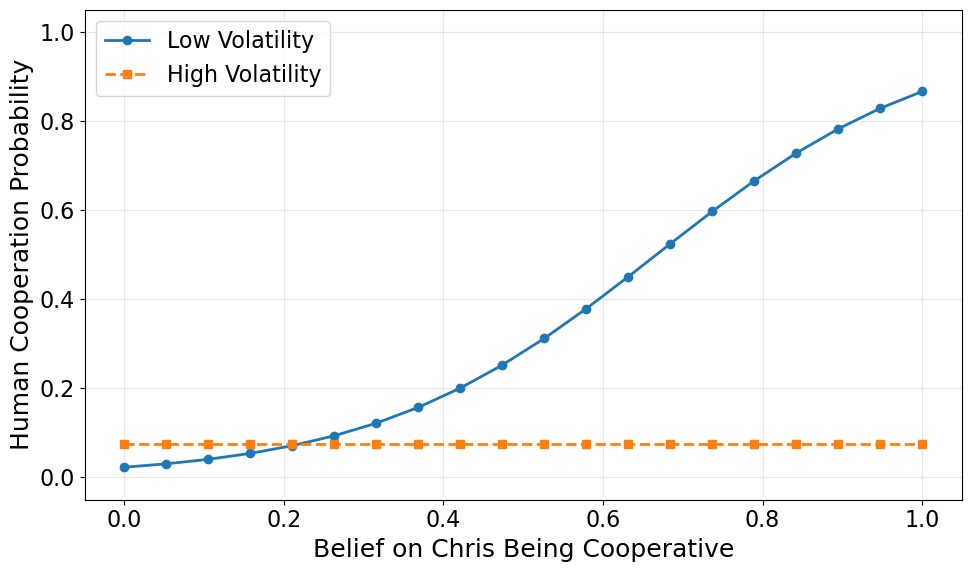

In [162]:
plt.rcParams.update({
    'font.size': 16,           # Base font size
    'axes.titlesize': 20,      # Subplot titles
    'axes.labelsize': 18,      # Axis labels
    'xtick.labelsize': 16,     # X-axis tick labels
    'ytick.labelsize': 16,     # Y-axis tick labels
    'legend.fontsize': 16      # Legend
})

plt.figure(figsize=(10, 6))

# Plot both lines
plt.plot(C, actions_low, marker='o', linestyle='-', label='Low Volatility', linewidth=2)
plt.plot(C, actions_high, marker='s', linestyle='--', label='High Volatility', linewidth=2)

# Labels and title
plt.xlabel('Belief on Chris Being Cooperative')
plt.ylabel('Human Cooperation Probability')
# plt.title('Cooperation Probability vs Belief under Different Volatility Levels', fontsize=16)

# Grid and legend
plt.grid(True, alpha=0.3)
plt.legend()

# Set y-axis limits if needed
plt.ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()